# Лабораторная работа №3: Классификация $kNN$

## Выполнил студент группы 6133-010402D Читоркин Егор Евгеньевич

In [1]:
import pandas as pd


1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

In [5]:
data = pd.read_csv('data.csv')


2. Бинарная классификация:
   - Привести описание датасета.

|Название признака|Значение признака|Единица измерения|
|-----------------|-----------------|-----------------|
|Price|Цена|Рубли|
|Apartment type|Тип|Первичное/вторичное|
|Metro station|Ближайшая станция метро|-|
|Minutes to metro|Время до ближайшей станции|Минуты|
|Region|Область|-|
|Number of rooms|Количество комнат|-|
|Area|Площадь|кв. м|
|Living area|Жилая площадь|кв. м|
|Kitchen area|Площадь кухни|кв. м|
|Floor|Этаж|-|
|Number of floors|Количество этажей в доме|-|
|Renovation|Внутренная отделка|-|

Будем определять Apartment type по оставльным признакам

   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             22676 non-null  float64
 1   Apartment type    22676 non-null  object 
 2   Metro station     22676 non-null  object 
 3   Minutes to metro  22676 non-null  float64
 4   Region            22676 non-null  object 
 5   Number of rooms   22676 non-null  float64
 6   Area              22676 non-null  float64
 7   Living area       22676 non-null  float64
 8   Kitchen area      22676 non-null  float64
 9   Floor             22676 non-null  float64
 10  Number of floors  22676 non-null  int64  
 11  Renovation        22676 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 2.1+ MB


In [7]:
for col in data.columns:
    print(f'{col}: {len(data[col].unique())} unique objects')

Price: 9979 unique objects
Apartment type: 2 unique objects
Metro station: 547 unique objects
Minutes to metro: 56 unique objects
Region: 2 unique objects
Number of rooms: 12 unique objects
Area: 3017 unique objects
Living area: 1302 unique objects
Kitchen area: 481 unique objects
Floor: 72 unique objects
Number of floors: 83 unique objects
Renovation: 4 unique objects


In [8]:
data['Region'].unique()

array(['Moscow region', 'Moscow'], dtype=object)

Null-ов нет, а о весе остальных признаков в целом рано говорить, так как даже Москва/Московская область в паре с ценой квартиры может дать много информации об Apartment type

   - Закодировать категориальные признаки при необходимости.

Категориальных признаков много, так что будем их кодировать. Если у признака будет много уникальных значений, то будем пользоваться label encoder, если их мало, то one-hot encoder, чтобы не сильно перегружать датасет

In [9]:
category = [var for var in data.columns if data[var].dtype == 'object']
category

['Apartment type', 'Metro station', 'Region', 'Renovation']

In [10]:
for col in category:
    print(f'{col}: {len(data[col].unique())} unique objects')

Apartment type: 2 unique objects
Metro station: 547 unique objects
Region: 2 unique objects
Renovation: 4 unique objects


Region, Renovation закодируем One-Hot Encoder'ом

Metro station - Label Encoder'ом (все-таки 547 новых столбцов - это too much)

In [11]:
cols = ['Region', 'Renovation']
data = pd.get_dummies(data=data, columns=cols, drop_first=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Price                                 22676 non-null  float64
 1   Apartment type                        22676 non-null  object 
 2   Metro station                         22676 non-null  object 
 3   Minutes to metro                      22676 non-null  float64
 4   Number of rooms                       22676 non-null  float64
 5   Area                                  22676 non-null  float64
 6   Living area                           22676 non-null  float64
 7   Kitchen area                          22676 non-null  float64
 8   Floor                                 22676 non-null  float64
 9   Number of floors                      22676 non-null  int64  
 10  Region_Moscow                         22676 non-null  uint8  
 11  Region_Moscow r

In [12]:
keys, values = pd.factorize(data['Metro station'].unique())
d = dict(zip(values, keys))

In [13]:
data['Apartment type'].unique()

array(['Secondary', 'New building'], dtype=object)

In [14]:
data['Metro station'] = data['Metro station'].replace(d)
data['Apartment type'] = data['Apartment type'].replace({'Secondary': 0, 'New building': 1})

In [15]:
data.head()

,Price,Apartment type,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Region_Moscow,Region_Moscow region,Renovation_Cosmetic,Renovation_Designer,Renovation_European-style renovation,Renovation_Without renovation
0,6300000.0,0,0,6.0,1.0,30.6,11.1,8.5,25.0,25,0,1,1,0,0,0
1,9000000.0,0,1,2.0,1.0,49.2,20.0,10.0,6.0,15,0,1,0,0,1,0
2,11090000.0,0,2,14.0,1.0,44.7,16.2,13.1,10.0,25,0,1,1,0,0,0
3,8300000.0,0,3,8.0,1.0,35.1,16.0,11.0,12.0,33,0,1,0,0,1,0
4,6450000.0,0,0,6.0,1.0,37.7,15.2,4.0,5.0,5,0,1,0,0,0,1


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Price                                 22676 non-null  float64
 1   Apartment type                        22676 non-null  int64  
 2   Metro station                         22676 non-null  int64  
 3   Minutes to metro                      22676 non-null  float64
 4   Number of rooms                       22676 non-null  float64
 5   Area                                  22676 non-null  float64
 6   Living area                           22676 non-null  float64
 7   Kitchen area                          22676 non-null  float64
 8   Floor                                 22676 non-null  float64
 9   Number of floors                      22676 non-null  int64  
 10  Region_Moscow                         22676 non-null  uint8  
 11  Region_Moscow r

   - Выбрать какое-нибудь значение гиперпараметра $k$ алгоритма $kNN$.

In [17]:
k = 3

   - Разбить выборку на обучающую и тестовую.
     > Разбиение использовать одно и то же для всех последующих манипуляций.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = data.drop('Apartment type', axis=1)
y = data['Apartment type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(y_train.shape, y_test.shape)

(15873,) (6803,)


   - Осуществить бинарную классификацию.

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
baseline_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

In [22]:
baseline_model.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [23]:
preds = baseline_model.predict(X_test)

   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [25]:
print(f'Accuracy:\t{accuracy_score(y_test, preds)}')
print(f'Precision:\t{precision_score(y_test, preds)}')
print(f'Recall:\t{recall_score(y_test, preds)}')
print(f'F1-measure:\t{f1_score(y_test, preds)}')
print(classification_report(y_test, preds))

Accuracy:	0.89519329707482
Precision:	0.8882374496152436
Recall:	0.8559322033898306
F1-measure:	0.8717856500629383
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3971
           1       0.89      0.86      0.87      2832

    accuracy                           0.90      6803
   macro avg       0.89      0.89      0.89      6803
weighted avg       0.90      0.90      0.89      6803



   - Нормализовать данные (`StandardScaler`или `MinMaxScaler`).

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
all_cols = list(X_train.columns)
scaler = StandardScaler()
scaler.fit(X[all_cols])
scaled = scaler.transform(X_train[all_cols])
data_scaled = pd.DataFrame(scaled, columns=all_cols)
data_scaled.head()

,Price,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Region_Moscow,Region_Moscow region,Renovation_Cosmetic,Renovation_Designer,Renovation_European-style renovation,Renovation_Without renovation
0,-0.303914,-0.315461,2.274447,-0.684669,-0.496830,-0.511967,-0.335677,0.504585,0.045393,0.638209,-0.638209,-1.137227,-0.392272,2.277167,-0.405198
1,-0.378772,0.460425,0.179132,-1.341030,-0.752801,-0.682466,-0.555659,-1.084854,-0.772679,0.638209,-0.638209,-1.137227,-0.392272,-0.439142,2.467931
2,-0.359014,0.110927,0.017954,-0.684669,-0.590296,-0.745419,-0.038055,0.637039,0.352171,-1.566885,1.566885,0.879332,-0.392272,-0.439142,-0.405198
3,2.703072,-1.776363,-0.304402,2.597134,5.090653,0.301181,3.727520,0.504585,-0.159125,0.638209,-0.638209,-1.137227,2.549250,-0.439142,-0.405198
4,-0.292444,-0.154692,-0.143224,-0.684669,-0.492442,-0.504098,-0.542719,0.504585,0.045393,0.638209,-0.638209,0.879332,-0.392272,-0.439142,-0.405198


   - Осуществить бинарную классификацию.

In [28]:
scaled_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

In [29]:
scaled_model.fit(data_scaled, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [30]:
preds_scaled = scaled_model.predict(scaler.transform(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [31]:
print(f'Accuracy:\t{accuracy_score(y_test, preds_scaled)}')
print(f'Precision:\t{precision_score(y_test, preds_scaled)}')
print(f'Recall:\t{recall_score(y_test, preds_scaled)}')
print(f'F1-measure:\t{f1_score(y_test, preds_scaled)}')
print(classification_report(y_test, preds_scaled))

Accuracy:	0.9819197412906071
Precision:	0.9724450645273806
Recall:	0.9844632768361582
F1-measure:	0.9784172661870505
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3971
           1       0.97      0.98      0.98      2832

    accuracy                           0.98      6803
   macro avg       0.98      0.98      0.98      6803
weighted avg       0.98      0.98      0.98      6803



   - Сравнить метрики на данных без нормализации и с применением нормализации.

Все метрики очень сильно выросли, что говорит о том, что нормализация крайне положительно влияет на качество обучения

     > Далее используем нормализованные данные.
   - Построить `сorrelation heatmap` и/или воспользоваться методом `corr()`. Выбрать наиболее важные признаки эвристически или на основании каких-нибудь вычислений.

In [32]:
import seaborn as sns

<Axes: >

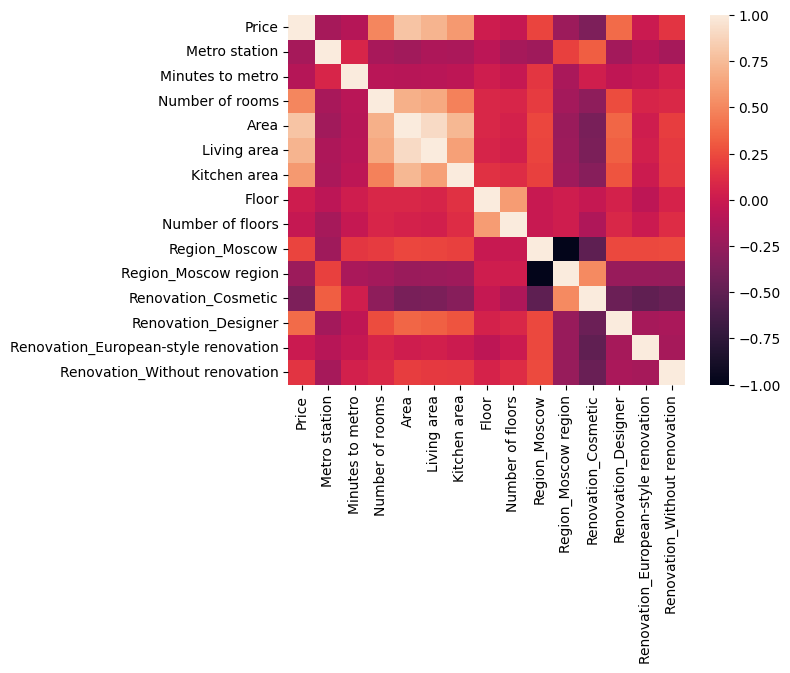

In [33]:
sns.heatmap(data_scaled.corr())

In [34]:
import numpy as np
matrix = data_scaled.corr()
np.fill_diagonal(matrix.values, 0)
threshold = 0.65
filtered_corr = matrix.abs() > threshold
feature_importance = filtered_corr.sum(axis=1)
sorted_features = feature_importance.sort_values(ascending=False)
filter_threshold = 0
selected_features = sorted_features[sorted_features > filter_threshold].index
print(selected_features)

Index(['Area', 'Living area', 'Price', 'Number of rooms', 'Kitchen area',
       'Region_Moscow', 'Region_Moscow region'],
      dtype='object')


   - Осуществить бинарную классификацию с отфильтрованными признаками.

In [35]:
filter_model = KNeighborsClassifier(n_neighbors=k,  metric='euclidean')

In [36]:
filter_model.fit(data_scaled[selected_features], y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [37]:
filter_preds = filter_model.predict(pd.DataFrame(scaler.transform(X_test), columns=all_cols)[selected_features])

   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [38]:
print(f'Accuracy:\t{accuracy_score(y_test, filter_preds)}')
print(f'Precision:\t{precision_score(y_test, filter_preds)}')
print(f'Recall:\t{recall_score(y_test, filter_preds)}')
print(f'F1-measure:\t{f1_score(y_test, filter_preds)}')
print(classification_report(y_test, filter_preds))

Accuracy:	0.974276054681758
Precision:	0.9592118907708261
Recall:	0.9798728813559322
F1-measure:	0.9694323144104804
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3971
           1       0.96      0.98      0.97      2832

    accuracy                           0.97      6803
   macro avg       0.97      0.98      0.97      6803
weighted avg       0.97      0.97      0.97      6803



   - Сравнить результаты "до" и "после" фильтрации, сделать выводы.

Метрики немного ухудшились, но у нас теперь гораздо меньше признаков используется, что определенно хорошо

   - Перебрать значения гиперпараметра $k$ в каком-нибудь диапазоне с использованием кросс-валидации на данных
     > данных - исходных данных до разбиения с применением нормализации
   
     с отфильтрованными признаками. Построить график *train/test accuracy* в зависимости от значения $k$.

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
X_scaled = pd.DataFrame(scaler.transform(X), columns=all_cols)[selected_features]
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=all_cols)[selected_features]
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=all_cols)[selected_features]

train_score = []
test_score = []
crossval_score = []

for k in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_scaled, y, cv = 10)
    print(f"Neighbors: {k}, folds count: 10 avg score: {scores.mean()}")
    crossval_score.append(scores.mean())
    model.fit(X_train_scaled, y_train)
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    train_score.append(accuracy_score(y_train, pred_train))
    test_score.append(accuracy_score(y_test, pred_test))



Neighbors: 1, folds count: 10 avg score: 0.9423666882165632
Neighbors: 2, folds count: 10 avg score: 0.9406908142204422
Neighbors: 3, folds count: 10 avg score: 0.9422787576367933
Neighbors: 4, folds count: 10 avg score: 0.9405150308583627
Neighbors: 5, folds count: 10 avg score: 0.9399417997197734
Neighbors: 6, folds count: 10 avg score: 0.9396775022969699
Neighbors: 7, folds count: 10 avg score: 0.938134195173601
Neighbors: 8, folds count: 10 avg score: 0.9383106787128254
Neighbors: 9, folds count: 10 avg score: 0.9358853428806377
Neighbors: 10, folds count: 10 avg score: 0.935708956588239
Neighbors: 11, folds count: 10 avg score: 0.932842606401642
Neighbors: 12, folds count: 10 avg score: 0.9331513845225065
Neighbors: 13, folds count: 10 avg score: 0.9304611872359263
Neighbors: 14, folds count: 10 avg score: 0.9300641867948146
Neighbors: 15, folds count: 10 avg score: 0.9277712427910927
Neighbors: 16, folds count: 10 avg score: 0.9284767685113223
Neighbors: 17, folds count: 10 avg s

In [41]:
from matplotlib import pyplot as plt

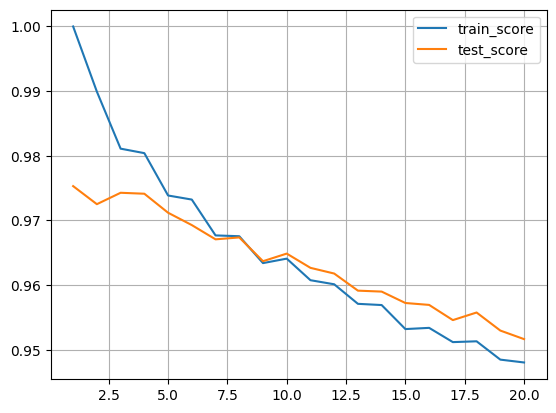

In [42]:
plt.plot(range(1, 21), train_score, label="train_score")
plt.plot(range(1, 21), test_score, label="test_score")
plt.legend()
plt.grid()

3. Многоклассовая классификация:
   - Привести описание датасета.
   - Осуществить предобработку данных - "подчистить данные".

Датасет не меняется, поэтому тут все аналогично бинарной классификации

In [43]:
data = pd.read_csv('data.csv')

- Закодировать категориальные признаки при необходимости.

Будем теперь предсказывать Renovation

In [44]:
cols = ['Region', 'Apartment type']
data = pd.get_dummies(data=data, columns=cols, drop_first=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        22676 non-null  float64
 1   Metro station                22676 non-null  object 
 2   Minutes to metro             22676 non-null  float64
 3   Number of rooms              22676 non-null  float64
 4   Area                         22676 non-null  float64
 5   Living area                  22676 non-null  float64
 6   Kitchen area                 22676 non-null  float64
 7   Floor                        22676 non-null  float64
 8   Number of floors             22676 non-null  int64  
 9   Renovation                   22676 non-null  object 
 10  Region_Moscow                22676 non-null  uint8  
 11  Region_Moscow region         22676 non-null  uint8  
 12  Apartment type_New building  22676 non-null  uint8  
 13  Apartment type_S

In [45]:
keys, values = pd.factorize(data['Metro station'].unique())
d = dict(zip(values, keys))

In [46]:
data['Renovation'].unique()

array(['Cosmetic', 'European-style renovation', 'Without renovation',
       'Designer'], dtype=object)

In [47]:
data['Metro station'] = data['Metro station'].replace(d)
data['Renovation'] = data['Renovation'].replace(
    {
        'Cosmetic': 0,
        'European-style renovation': 1,
        'Without renovation': 2,
        'Designer': 3,
    }
)

In [48]:
data.head()

,Price,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation,Region_Moscow,Region_Moscow region,Apartment type_New building,Apartment type_Secondary
0,6300000.0,0,6.0,1.0,30.6,11.1,8.5,25.0,25,0,0,1,0,1
1,9000000.0,1,2.0,1.0,49.2,20.0,10.0,6.0,15,1,0,1,0,1
2,11090000.0,2,14.0,1.0,44.7,16.2,13.1,10.0,25,0,0,1,0,1
3,8300000.0,3,8.0,1.0,35.1,16.0,11.0,12.0,33,1,0,1,0,1
4,6450000.0,0,6.0,1.0,37.7,15.2,4.0,5.0,5,2,0,1,0,1


- Нормализовать данные.

In [49]:
scaler = StandardScaler()
X = data.drop('Renovation', axis=1)
y = data['Renovation']
all_cols = X.columns
X = pd.DataFrame(scaler.fit_transform(X), columns=all_cols)

- Выбрать какое-нибудь значение гиперпараметра $k$ алгоритма $kNN$.

In [50]:
k = 5

   - Разбить выборку на обучающую и тестовую.
     > Разбиение использовать одно и то же для данных без фильтрации признаков и с применением фильтрации.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(y_train.shape, y_test.shape)

(15873,) (6803,)


   - Осуществить многоклассовую классификацию.

In [52]:
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)
preds = model.predict(X_test)

   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [53]:
print(f'Accuracy:\t{accuracy_score(y_test, preds)}')
print(f'Precision (micro):\t{precision_score(y_test, preds, average="micro")}')
print(f'Recall (micro):\t{recall_score(y_test, preds, average="micro")}')
print(f'F1-measure (micro):\t{f1_score(y_test, preds, average="micro")}')
print(classification_report(y_test, preds))

Accuracy:	0.7029251800676172
Precision (micro):	0.7029251800676172
Recall (micro):	0.7029251800676172
F1-measure (micro):	0.7029251800676172
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3825
           1       0.44      0.43      0.43      1087
           2       0.52      0.45      0.48       989
           3       0.59      0.43      0.50       902

    accuracy                           0.70      6803
   macro avg       0.59      0.55      0.57      6803
weighted avg       0.69      0.70      0.69      6803



   - Построить `сorrelation heatmap` и/или воспользоваться методом `corr()`. Выбрать наиболее важные признаки эвристически или на основании каких-нибудь вычислений

<Axes: >

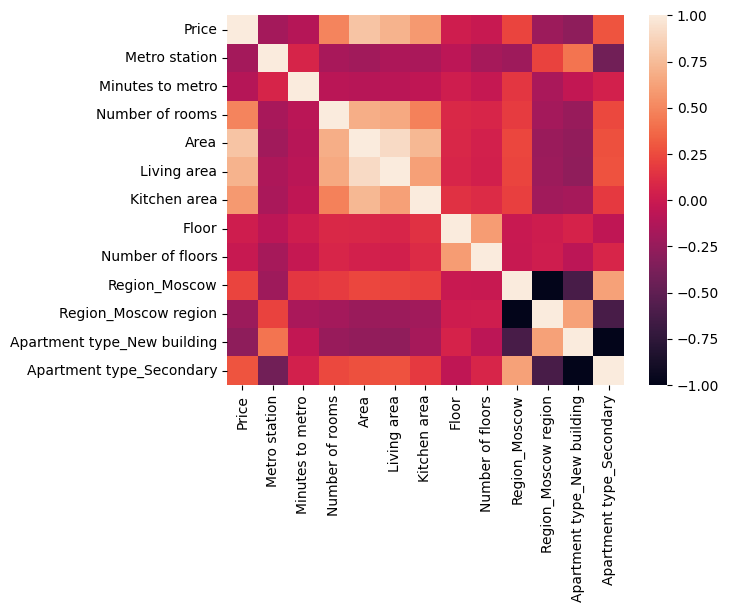

In [54]:
sns.heatmap(X.corr())

In [55]:
matrix = X.corr()
np.fill_diagonal(matrix.values, 0)
threshold = 0.7
filtered_corr = matrix.abs() > threshold
feature_importance = filtered_corr.sum(axis=1)
sorted_features = feature_importance.sort_values(ascending=False)
filter_threshold = 0
selected_features = sorted_features[sorted_features > filter_threshold].index
print(selected_features)

Index(['Area', 'Price', 'Living area', 'Kitchen area', 'Region_Moscow',
       'Region_Moscow region', 'Apartment type_New building',
       'Apartment type_Secondary'],
      dtype='object')


   - Осуществить многоклассовую классификацию с отфильтрованными признаками.

In [56]:
X_f = X[selected_features]
X_train_f = X_train[selected_features]
X_test_f = X_test[selected_features]

In [57]:
model_f = KNeighborsClassifier(n_neighbors=k)
model_f.fit(X_train_f, y_train)
preds_f = model_f.predict(X_test_f)

   - Посчитать метрики: $accuracy$, $precision$, $recall$, $\textit{f-measure}$, а также составить `classification_report`.

In [58]:
print(f'Accuracy:\t{accuracy_score(y_test, preds_f)}')
print(f'Precision (micro):\t{precision_score(y_test, preds_f, average="micro")}')
print(f'Recall (micro):\t{recall_score(y_test, preds_f, average="micro")}')
print(f'F1-measure (micro):\t{f1_score(y_test, preds_f, average="micro")}')
print(classification_report(y_test, preds_f))

Accuracy:	0.698074378950463
Precision (micro):	0.698074378950463
Recall (micro):	0.698074378950463
F1-measure (micro):	0.698074378950463
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3825
           1       0.43      0.46      0.45      1087
           2       0.47      0.40      0.43       989
           3       0.56      0.39      0.46       902

    accuracy                           0.70      6803
   macro avg       0.57      0.54      0.55      6803
weighted avg       0.68      0.70      0.69      6803



   - Сравнить результаты "до" и "после" фильтрации, сделать выводы.

Качество осталось примерно на том же уровне, что и было ранее, однако теперь оно обеспечивается меньшим количеством признаков

   - Перебрать значения гиперпараметра $k$ в каком-нибудь диапазоне с использованием кросс-валидации на данных
      > данных - исходных данных до разбиения

     с отфильтрованными признаками. Построить график *train/test accuracy* в зависимости от значения $k$.

In [59]:
train_score = []
test_score = []
crossval_score = []

for k in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_f, y, cv = 10)
    print(f"Neighbors: {k}, folds count: 10 avg score: {scores.mean()}")
    crossval_score.append(scores.mean())
    model.fit(X_train_f, y_train)
    pred_train = model.predict(X_train_f)
    pred_test = model.predict(X_test_f)
    train_score.append(accuracy_score(y_train, pred_train))
    test_score.append(accuracy_score(y_test, pred_test))

Neighbors: 1, folds count: 10 avg score: 0.6430260022452348
Neighbors: 2, folds count: 10 avg score: 0.6256056532302672
Neighbors: 3, folds count: 10 avg score: 0.6256080066034484
Neighbors: 4, folds count: 10 avg score: 0.6167889837239934
Neighbors: 5, folds count: 10 avg score: 0.6158629605512418
Neighbors: 6, folds count: 10 avg score: 0.6147162454323165
Neighbors: 7, folds count: 10 avg score: 0.6153344046043648
Neighbors: 8, folds count: 10 avg score: 0.6132176912981206
Neighbors: 9, folds count: 10 avg score: 0.6133940581411542
Neighbors: 10, folds count: 10 avg score: 0.6094693318520696
Neighbors: 11, folds count: 10 avg score: 0.6078817385242911
Neighbors: 12, folds count: 10 avg score: 0.6087193643325095
Neighbors: 13, folds count: 10 avg score: 0.6065590649990004
Neighbors: 14, folds count: 10 avg score: 0.6039569538871113
Neighbors: 15, folds count: 10 avg score: 0.6040892873674817
Neighbors: 16, folds count: 10 avg score: 0.604574451780745
Neighbors: 17, folds count: 10 avg

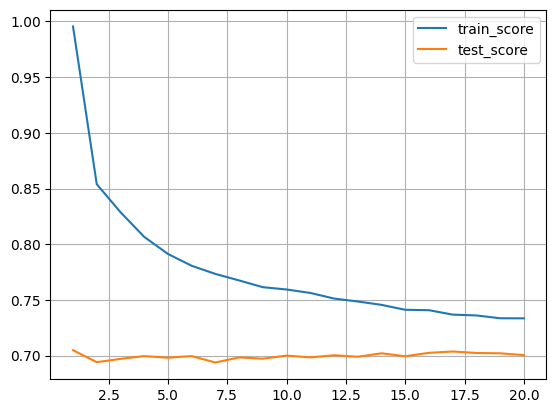

In [60]:
plt.plot(range(1, 21), train_score, label="train_score")
plt.plot(range(1, 21), test_score, label="test_score")
plt.legend()
plt.grid()

   - Для лучшего классификатора привести метрики, `classification_report`, построить `confusion matrix`.

Будем смотреть лучший результат по тестовой выборке (исключая тривиальный случай $k=1$)

In [61]:
best = test_score.index(max(test_score[1:]))
best

16

Т.е. лучший результат на тестовой выборке достигается при $k=15$

In [62]:
model_f = KNeighborsClassifier(n_neighbors=15)
model_f.fit(X_train_f, y_train)
preds_f = model_f.predict(X_test_f)

In [63]:
print(classification_report(y_test, preds_f))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87      3825
           1       0.43      0.40      0.41      1087
           2       0.47      0.36      0.41       989
           3       0.57      0.47      0.52       902

    accuracy                           0.70      6803
   macro avg       0.58      0.54      0.55      6803
weighted avg       0.68      0.70      0.69      6803



In [64]:
from sklearn.metrics import confusion_matrix

<Axes: >

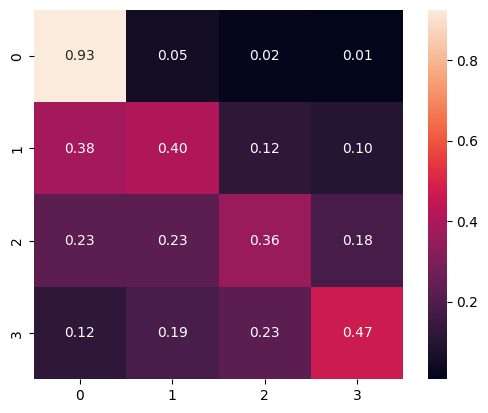

In [65]:
sns.heatmap(data=confusion_matrix(y_test, preds_f, normalize='true'), square=True, annot=True, fmt='.2f')